In [1]:
#Importing Packages
import xarray as xr
from tinygp import kernels
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import arviz as az
import geopandas as gpd
import cartopy.crs as ccrs
import arviz as az
from src.model_fitting_functions import run_inference
from src.residuals_functions import singleGP_model

plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.4

rng_key = random.PRNGKey(3)
rng_key, rng_key_ = random.split(rng_key)
jax.config.update("jax_enable_x64", True)

In [2]:
#Loading Output from MCMC
outfile_dir = '/home/jez/Bias_Correction/data/Residual_Model/'
ds_prior = xr.open_dataset(f'{outfile_dir}idata_residual_singlegp_prior.nc')
idata_matern32 = az.from_netcdf(f'{outfile_dir}idata_residual_singlegp_matern32.nc')
idata_expsq = az.from_netcdf(f'{outfile_dir}idata_residual_singlegp_expsq.nc')

In [6]:
az.summary(ds_prior,hdi_prob=0.95)

Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kern_var,6.025,3.380,0.574,12.312,0.061,0.043,2559.0,2064.0,NaN
lengthscale,5.971,3.359,0.774,12.451,0.050,0.035,3998.0,2924.0,NaN
mean,-0.005,2.032,-3.977,3.803,0.045,0.032,2067.0,2876.0,NaN


In [7]:
az.summary(idata_matern32,hdi_prob=0.95)

Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kern_var,6.254,0.927,4.512,7.734,0.038,0.027,571.0,466.0,NaN
lengthscale,3.318,0.463,2.448,4.221,0.016,0.011,835.0,1022.0,NaN
mean,0.845,0.495,-0.058,1.796,0.019,0.016,681.0,516.0,NaN


In [8]:
az.summary(idata_expsq,hdi_prob=0.95)

Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kern_var,6.636,1.375,4.177,9.236,0.035,0.025,1590.0,1684.0,NaN
lengthscale,1.917,0.311,1.306,2.507,0.008,0.006,1353.0,1266.0,NaN
mean,0.720,0.417,-0.047,1.584,0.011,0.008,1381.0,1261.0,NaN


In [21]:
realisations_matern32_obs = singleprocess_posterior_predictive_realisations(
        ox,ox,idata_matern32,onoise,10,10)
realisations_expsq_obs = singleprocess_posterior_predictive_realisations(
        ox,ox,idata_expsq,onoise,10,10)

difference_matern32 = realisations_matern32_obs.mean(axis=(0,1))-odata
difference_expsq = realisations_expsq_obs.mean(axis=(0,1))-odata

realisations_matern32 = singleprocess_posterior_predictive_realisations(
        nx,ox,idata_matern32,onoise,10,10)
realisations_expsq = singleprocess_posterior_predictive_realisations(
        nx,ox,idata_expsq,onoise,10,10)

100%|██████████| 10/10 [04:52<00:00, 29.28s/it]


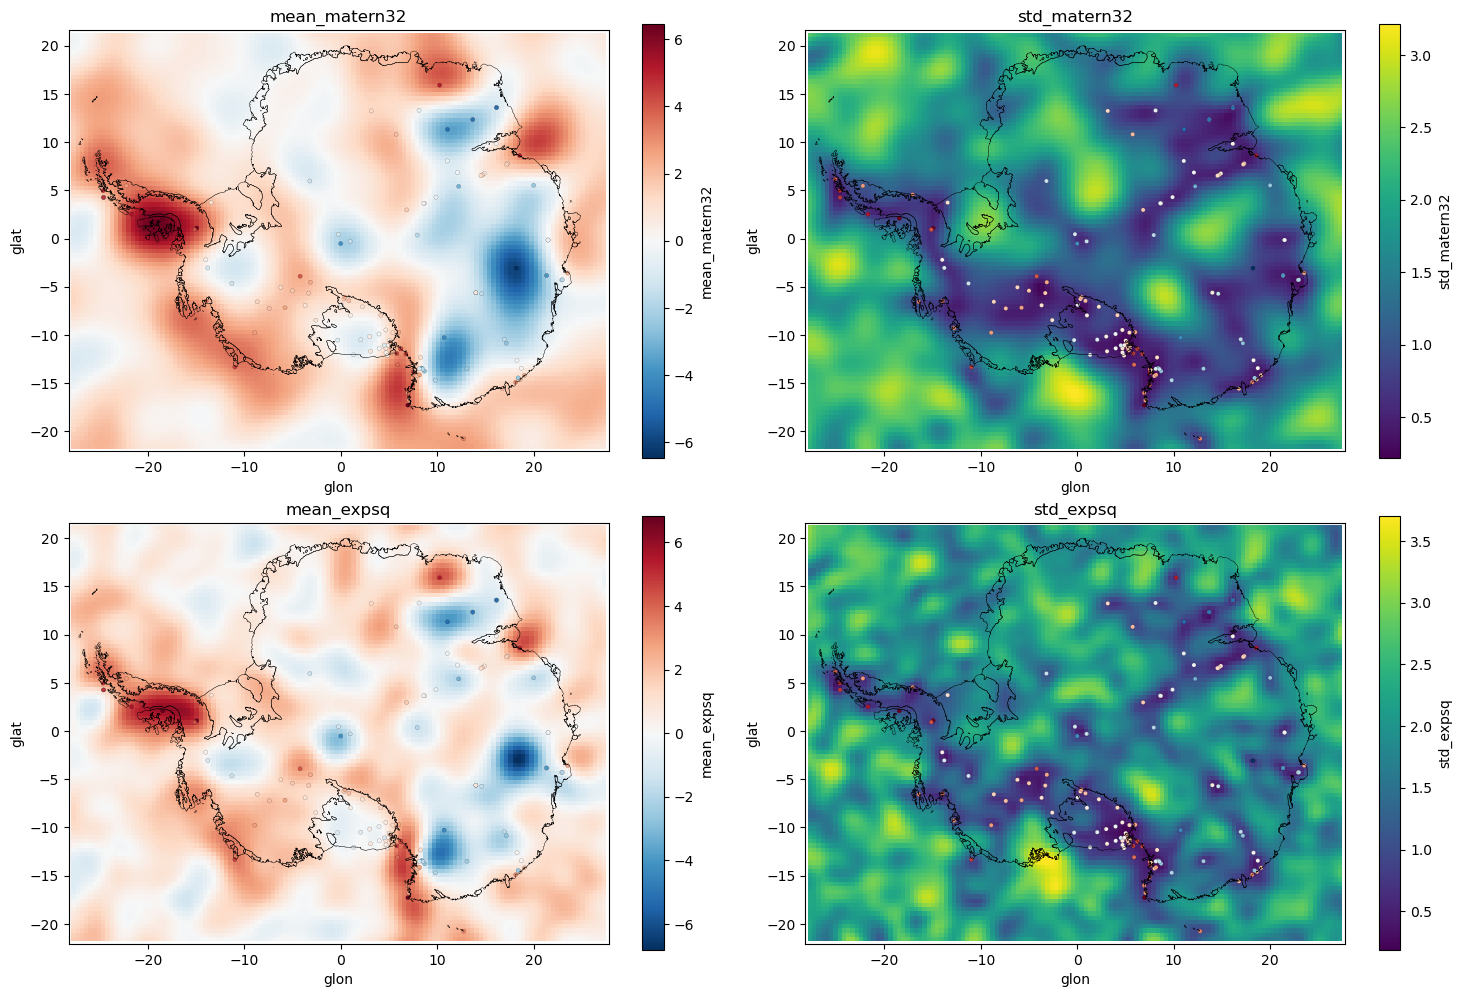

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

vars = ['mean_matern32','std_matern32','mean_expsq','std_expsq']

for i,var in zip(range(4),vars):
    plt.subplot(2, 2, i+1)
    ds_predictions[var].plot.pcolormesh(
        x='glon',y='glat')#,vmin=vmin,vmax=vmax)
    plt.title(var)

min_glon, max_glon = ds_predictions.glon.min()-0.5,ds_predictions.glon.max()+0.5
min_glat, max_glat = ds_predictions.glat.min()-0.5,ds_predictions.glat.max()+0.5
for ax in axs.ravel():
    ax.set_xlim([min_glon, max_glon])
    ax.set_ylim([min_glat, max_glat])
    antarctica_gdf.boundary.plot(ax=ax, color="k", linewidth=0.3)

for row in axs:
    for ax in row:
        ax.scatter(
            x=ds_obs_stacked.glon,y=ds_obs_stacked.glat,
            c=ds_obs_stacked['Temperature Residual'],
            cmap = 'RdBu_r',
            vmin=-6,
            vmax=6,
            edgecolors='k',
            linewidths=0.1)  

plt.tight_layout()

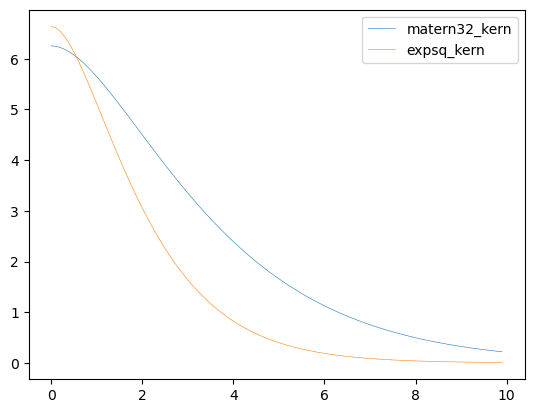

In [62]:
x0 = np.array([0])
x1 = np.arange(0,10,0.1)
kerns = [matern32_kern,expsq_kern]
labels = ['matern32_kern','expsq_kern']
for kern,label in zip(kerns,labels):
    plt.plot(x1,kern(x0,x1)[0],label=label)
plt.legend()

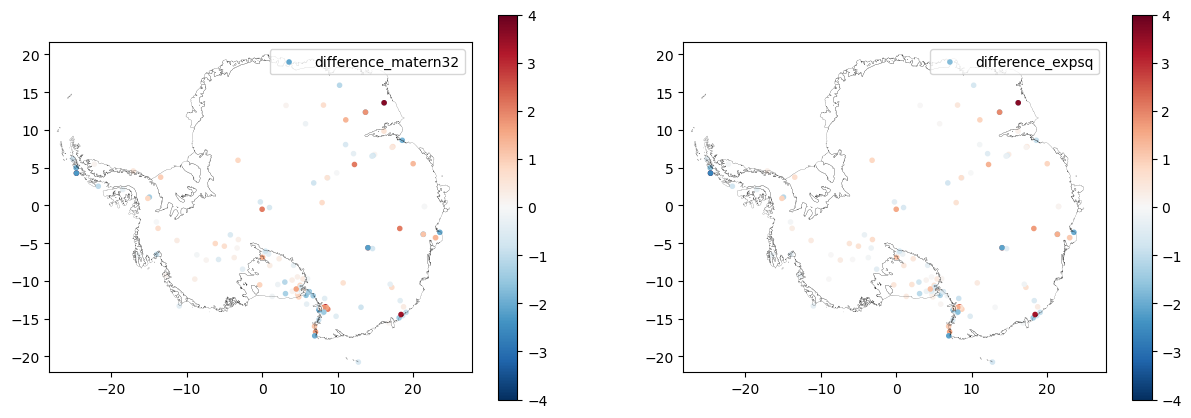

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
datasets = [difference_matern32,difference_expsq]
labels = ['difference_matern32','difference_expsq']
plots = []

for ax,data,label in zip(axs,datasets,labels):
    plots.append(
            ax.scatter(
            x=ds_obs_stacked.glon,y=ds_obs_stacked.glat,
            c=data,
            cmap = 'RdBu_r',
            vmin=-4,
            vmax=4,
            label=label)
    )
    ax.legend()

for plot in plots:
    plt.colorbar(plot)

min_glon, max_glon = ds_predictions.glon.min()-0.5,ds_predictions.glon.max()+0.5
min_glat, max_glat = ds_predictions.glat.min()-0.5,ds_predictions.glat.max()+0.5
for ax in axs.ravel():
    ax.set_xlim([min_glon, max_glon])
    ax.set_ylim([min_glat, max_glat])
    antarctica_gdf.boundary.plot(ax=ax, color="k", linewidth=0.1)

# antarctica_gdf.boundary.plot(ax=axs, color="k", linewidth=0.1)